# Sky with the Moon Up

* https://desi.lbl.gov/trac/wiki/CommissioningCommissioningPlanning/commishdata#NightSky
* https://portal.nersc.gov/project/desi/collab/nightwatch/kpno/20191112/exposures.html
* http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-11-12/nightsum.html

**Data**  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112
* Exposures 27337-27396

**Data Model**  
* https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures/NIGHT/EXPID/sky-CAMERA-EXPID.html

John Moustakas

In [1]:
import os, sys, glob, pdb
import numpy as np
import fitsio

In [2]:
from astropy.table import Table, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord

import astropy.time
import astropy.coordinates
  
# hack!
from astropy.utils.iers import conf
from astropy.utils import iers
conf.auto_max_age = None  
iers.Conf.iers_auto_url.set('ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all')    

loc = astropy.coordinates.EarthLocation.of_site('Kitt Peak')

In [19]:
import desispec.io
import desimodel.io
import desimodel.io

In [4]:
# https://astroplan.readthedocs.io/en/v0.1/_modules/astroplan/moon.html
import ephem

def moon_phase_angle(time, location):
    sun = astropy.coordinates.get_sun(time).transform_to(astropy.coordinates.AltAz(
        location=location, obstime=time))
    moon = astropy.coordinates.get_moon(time, location)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))

def moon_illumination(time, location):
    i = moon_phase_angle(time, location)
    k = (1 + np.cos(i))/2.0
    return k.value

import speclite
import specsim.atmosphere
import specsim.simulator

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='talk', style='ticks', font_scale=1.1)
%matplotlib inline

In [6]:
allcam = ('b', 'r', 'z')
allspec = ['{}'.format(nn) for nn in np.arange(10)]
topdir = os.getenv('DESI_ROOT')+'/spectro'

#### Initialize access to the online database.

https://github.com/desihub/desicmx/blob/master/analysis/gfa/DESI-Online-Database-Tutorial.ipynb

In [7]:
dbfile = os.getenv('HOME')+'/software/desi-telemetry-db.yaml'
if not os.path.exists(dbfile):
    import getpass
    pw = getpass.getpass(prompt='Enter database password: ')
    with open(dbfile, 'w') as f:
        print('host: db.replicator.dev-cattle.stable.spin.nersc.org', file=f)
        print('dbname: desi_dev', file=f)
        print('port: 60042', file=f)
        print('user: desi_reader', file=f)
        print(f'password: {pw}', file=f)
    print('Created {}'.format(dbfile))

In [8]:
from desietcimg.db import DB, Exposures, NightTelemetry
db = DB(config_name=dbfile)
ExpInfo = Exposures(db)
print(ExpInfo.what)
TcsInfo = NightTelemetry(db, 'tcs_info')
print(TcsInfo(20191112).columns)
#dir(exp(27339))

id,data_location,thumbnail,errors,targtra,targtdec,telstat,skyra,skydec,reqra,reqdec,deltara,deltadec,reqtime,exptime,flavor,program,lead,propid,object,instance,utc_dark,utc_beg,utc_end,positioned,prepared,started,exposed,digitized,built,distributed,paused,aborted,saved,saved_updated,discard,aos,seeing,guider,focus,tileid,inposition,positer,ntargets,seqid,seqnum,seqtot,moonangl,airmass,mountha,zd,mountaz,domeaz,st,vccd,raoffset,decoffset,slewangl,readout_time,hexapod_time,slew_time,time_between_exposures,script,manifest,spectrographs,update_time,frames,multiframe,reqha,reqaz,reqel,image_cameras,guide_cameras,focus_cameras,excluded,fiberassign,s2n,transpar,skylevel,zenith,dominpos,whitespt,inpos,inctrl,mjd_obs,date_obs,moonra,moondec,guider_mode,etc,collected,night,ups,dome,computer,telescope,tower,parallactic,tcsmjd,pmready,mntoffd,mntoffr,se_annex,guidoffr,guidoffd,petals,cal_lamps,skytime,focstime,guidtime,mountel,hexapod,adc,action,sequence,observers,exposing,done,digitizing,obstype

In [9]:
#ss = desispec.io.read_sky('/global/project/projectdirs/desi/spectro/redux/daily/exposures/20191112/00027345/sky-r3-00027345.fits')
#ss.header[:40]

In [10]:
#tcsinfo = tcs('20191112')
#ii = np.argmin(np.abs(tcsinfo.mjd.values-58800.22016993))
#tcsinfo.iloc[ii]

In [42]:
fp = desimodel.io.load_fiberpos()
tt = desimodel.io.load_throughput('r')
tt.extinction(tt._wave)

array([0.14797358, 0.14801762, 0.14820986, ..., 0.05506739, 0.05511871,
       0.05547868])

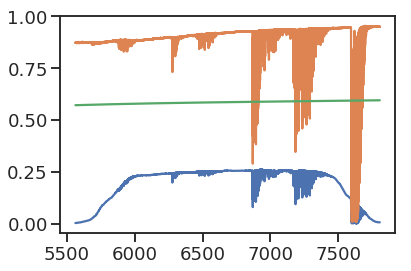

In [46]:
tt = desimodel.io.load_throughput('r')
plt.plot(tt._wave, tt.thru(tt._wave))
plt.plot(tt._wave, tt.atmospheric_throughput(tt._wave))
plt.plot(tt._wave, tt.fiberinput_throughput(tt._wave))

(0, 20000)

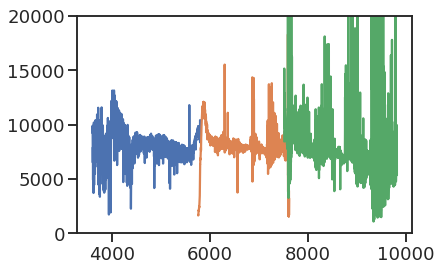

In [61]:
dd = '/global/project/projectdirs/desi/spectro/redux/daily/exposures/20191112/00027345'
for cam in ('b', 'r', 'z'):
    tt = desimodel.io.load_throughput(cam)
    sr = desispec.io.read_frame(dd+'/frame-{}3-00027345.fits'.format(cam))
    ss = desispec.io.read_sky(dd+'/sky-{}3-00027345.fits'.format(cam))
    plt.plot(ss.wave, ss.flux[0, :] / tt.thru(ss.wave))
plt.ylim(0, 20000)

In [67]:
sr.fibermap

TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SECONDARY_TARGET,TARGET_RA,TARGET_DEC,TARGET_RA_IVAR,TARGET_DEC_IVAR,BRICKID,BRICK_OBJID,MORPHTYPE,PRIORITY,SUBPRIORITY,REF_ID,PMRA,PMDEC,REF_EPOCH,PMRA_IVAR,PMDEC_IVAR,RELEASE,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_W1,FIBERFLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FIBERTOTFLUX_W1,FIBERTOTFLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,EBV,PHOTSYS,OBSCONDITIONS,NUMOBS_INIT,PRIORITY_INIT,NUMOBS_MORE,HPXPIXEL,FIBER,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,OBJTYPE,LAMBDA_REF,FIBERASSIGN_X,FIBERASSIGN_Y,FA_TARGET,FA_TYPE,NUMTARGET,FIBER_RA,FIBER_DEC,FIBER_RA_IVAR,FIBER_DEC_IVAR,PLATEMAKER_X,PLATEMAKER_Y,PLATEMAKER_RA,PLATEMAKER_DEC,NUM_ITER,SPECTROID
int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,str4,int32,float64,int64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int32,int64,int64,int32,int64,int32,int32,int32,int32,int32,str3,float32,float32,float32,int64,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,int32,int32
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,0,0,311,311,0,,5400.0,83.21898,-286.66373,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,4294967296,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,1,0,272,272,0,SKY,5400.0,59.109577,-273.27396,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,4294967296,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,2,0,252,252,0,SKY,5400.0,31.751867,-269.80435,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3,0,156,156,0,,5400.0,0.18432418,-221.17873,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4,0,198,198,0,,5400.0,-19.776659,-253.03535,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,5,0,204,204,0,,5400.0,41.488995,-240.11723,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,4294967296,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,6,0,233,233,0,SKY,5400.0,14.601016,-264.20517,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,7,0,172,172,0,,5400.0,17.358227,-226.7752,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,8,0,310,310,0,,5400.0,73.0176,-288.79773,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0


#### Troll the reduced data looking for processed sky exposures.

In [16]:
def gather_skyspec_info():
    allnights = glob.glob(topdir+'/redux/daily/exposures/20191112')
    #print(allnights)
    info = []
    for fullnight in sorted(allnights[:5]):
        night = os.path.basename(fullnight)
        tcs = TcsInfo(night)
        allexpids = glob.glob(fullnight+'/????????')
        #print(allexpids)
        for datadir in sorted(allexpids):
            expid = os.path.basename(datadir)
            #exptime = ExpInfo(expid, 'exptime')
            for cam in ('r'): # allcam:
                for spec in '3': # allspec:
                    skyfile = '{}/sky-{}{}-{}.fits'.format(datadir, cam, spec, expid)
                    #print(skyfile)
                    if os.path.isfile(skyfile):
                        #print('Reading {}'.format(skyfile))
                        sky = desispec.io.read_sky(skyfile)
                        pdb.set_trace()
                        
                        # gather metadata for this exposure and pack into an astropy Table
                        mjdobs = sky.header['MJD-OBS']
                        indx = np.argmin(np.abs(tcs['mjd'].values-mjdobs))
                        tel = tcs.iloc[indx]

                        info1 = Table()
                        info1['NIGHT'] = [night]
                        info1['EXPID'] = [expid]
                        info1['CAMERA'] = [cam]
                        info1['SPECTROGRAPH'] = [spec] # should get from the header...
                        info1['MJD-OBS'] = [mjdobs] # mid-exposure?
                        info1['EXPTIME'] = [sky.header['EXPTIME']]
                        info1['DATE-OBS'] = [sky.header['DATE-OBS']] # mid-exposure?
                        info1['DATE-UT'] = tel.date_ut # start of exposure?
                        info1['MJD'] = tel.mjd
                        info1['SKYRA'] = tel.sky_ra * u.degree
                        info1['SKYDEC'] = tel.sky_dec * u.degree
                        #info1['TARGRA'] = tel.target_ra
                        #info1['TARGDEC'] = tel.target_dec
                        info1['AIRMASS'] = tel.airmass.astype('f4')
                        info1['TEL_MOONRA'] = tel.moon_ra * u.degree
                        info1['TEL_MOONDEC'] = tel.moon_dec * u.degree
                        info.append(info1)
                        #pdb.set_trace()
    info = vstack(info)
    time = astropy.time.Time(info['MJD-OBS'], format='mjd')
    info['MOONPHASE'] = np.array([moon_illumination(astropy.time.Time(tt.to_datetime(), scale='utc'), loc) 
                                  for tt in time]).astype('f4')
    
    moonpos = astropy.coordinates.get_moon(time, loc)
    info['MOONRA'], info['MOONDEC'] = moonpos.ra, moonpos.dec
    
    # compute the moon separation in degrees
    csky = SkyCoord(ra=info['SKYRA'], dec=info['SKYDEC'], frame='icrs')
    cmoon = SkyCoord(ra=info['MOONRA'], dec=info['MOONDEC'], frame='icrs')
    info['MOONSEP'] = np.array(csky.separation(cmoon).value).astype('f4') # [degree]
    
    # get the zenith angle of the moon
    moon_altaz = moonpos.transform_to(astropy.coordinates.AltAz(obstime=time, location=loc))
    moon_az = moon_altaz.az.value * u.degree
    info['MOONAZ'] = moon_altaz.az
    info['MOONALT'] = moon_altaz.alt
    info['MOONZD'] = 90.0 * u.degree - moon_altaz.alt

    return info

In [17]:
%time info = gather_skyspec_info()

CPU times: user 8.02 s, sys: 223 ms, total: 8.24 s
Wall time: 8.74 s


In [18]:
info

NIGHT,EXPID,CAMERA,SPECTROGRAPH,MJD-OBS,EXPTIME,DATE-OBS,DATE-UT,MJD,SKYRA,SKYDEC,AIRMASS,TEL_MOONRA,TEL_MOONDEC,MOONPHASE,MOONRA,MOONDEC,MOONSEP,MOONAZ,MOONALT,MOONZD
,,,,,,,,,deg,deg,,deg,deg,,deg,deg,,deg,deg,deg
str8,str8,str1,str1,float64,float64,str26,str23,float64,float64,float64,float32,float64,float64,float32,float64,float64,float32,float64,float64,float64
20191112,00027339,r,3,58800.21473507,300.0,2019-11-13T05:09:13.110272,2019-11-13 05:08:37.006,58800.214747,49.75,25.5,1.141077,56.333564,16.377605,0.99409693,56.85856043923165,16.07724842599831,11.524085,104.45561792790541,50.97611775546215,39.02388224453785
20191112,00027345,r,3,58800.22016993,300.0,2019-11-13T05:17:02.681966,2019-11-13 05:16:25.006,58800.220164,49.75,25.5,1.123762,56.395408,16.39529,0.994051,56.90616119803401,16.101810201236407,11.529399,105.97634363439235,52.55602097708601,37.44397902291399
20191112,00027351,r,3,58800.22495802,300.0,2019-11-13T05:23:56.372934,2019-11-13 05:23:20.506,58800.224973,37.50248,25.498801,1.038195,56.457268,16.412958,0.99401087,56.947638024406714,16.123280239017017,20.416197,107.38928278199857,53.93834450474021,36.06165549525979
20191112,00027357,r,3,58800.22926841,300.0,2019-11-13T05:30:08.790208,2019-11-13 05:29:31.506,58800.229267,37.502271,25.498841,1.032291,56.510304,16.428089,0.9939749,56.984623185329184,16.1424694301304,20.437265,108.7269159589087,55.173924975739574,34.826075024260426
20191112,00027363,r,3,58800.23412718,300.0,2019-11-13T05:37:08.588146,2019-11-13 05:36:31.006,58800.234122,26.250271,25.49907,1.006716,56.572195,16.445726,0.99393463,57.02592810972053,16.163938443432762,30.154314,110.31802347439051,56.555207062621854,33.444792937378146
20191112,00027370,r,3,58800.23903292,300.0,2019-11-13T05:44:12.444153,2019-11-13 05:43:34.506,58800.239024,20.499259,25.499061,1.010434,56.642946,16.465863,0.99389416,57.0672355687316,16.185437389502262,35.295326,112.02478712067774,57.9356660553412,32.0643339446588
20191112,00027375,r,3,58800.24322416,300.0,2019-11-13T05:50:14.567826,2019-11-13 05:49:37.006,58800.243225,17.470357,25.579551,1.019079,56.696024,16.480951,0.99385977,57.10222535023157,16.203660698774726,38.041718,113.57234209071063,59.102135371688384,30.897864628311616
20191112,00027381,r,3,58800.24751194,300.0,2019-11-13T05:56:25.031235,2019-11-13 05:55:49.006,58800.247525,14.719447,25.578973,1.032191,56.749114,16.496027,0.9938247,57.13774706826327,16.222163376085323,40.53667,115.25065093153681,60.281405071518016,29.718594928481984


In [ ]:
stop

#### Previous code below here

In [ ]:
gfadir = '/project/projectdirs/desi/users/ameisner/GFA/reduced/v0001'

#### Load the GFA filter curve.

In [ ]:
def load_gfa_filter():
    if False:
        rfilt = speclite.filters.load_filter('decam2014-r')
    else:
        if False:
            filtfile = '/global/homes/a/ameisner/ci_throughput/etc/gfa_filter_transmission_DESI-1297.dat'
            filtwave, filtresp, _, _ = np.loadtxt(filtfile, unpack=True)
        else:
            filt = Table.read('/global/homes/a/ameisner/ci_throughput/etc/gfa_throughput-airmass_1.00.fits')
            filtwave, filtresp = filt['LAMBDA_NM'], filt['THROUGHPUT']
            
        filtresp[filtresp < 0] = 0
        filtresp[0] = 0
        filtresp[-1] = 0
        srt = np.argsort(filtwave)
        filtwave, filtresp = filtwave[srt] * 10, filtresp[srt]
        rfilt = speclite.filters.FilterResponse(wavelength=filtwave * u.Angstrom,
                                                response=filtresp,
                                                meta=dict(group_name='gfa', band_name='r'))
        
        return rfilt

In [ ]:
rfilt = load_gfa_filter()
plt.plot(rfilt.wavelength, rfilt.response)

#### Specify the night and range of GFA and spectrograph exposure IDs.

In [ ]:
night = 20191112
expid_start, expid_end = 27337, 27396
expids = np.arange(expid_end - expid_start + 1) + expid_start

In [ ]:
for col in ('airmass', 'skyra', 'skydec', 'moonangl', 'moonra', 'moondec'):
    print(col, ExpInfo(27339, col))

#### Read A. Meisner's reductions to get the sky background in the GFAs vs moon separation.

In [ ]:
def read_gfa(night, expid, raw=False):
    sexpid = '{:08d}'.format(expid)
    rawfname = topdir+'/data/{0}/{1}/gfa-{1}.fits.fz'.format(night, sexpid)
    fname = gfadir+'/{0}/{1}/gfa-{1}_ccds.fits'.format(night, sexpid)    
    if os.path.isfile(fname):
        # get the target-moon separation
        hdr = fitsio.read_header(rawfname, ext=1)
        #print(hdr)
        
        ra, dec, moonra, moondec = hdr['SKYRA'], hdr['SKYDEC'], hdr['MOONRA'], hdr['MOONDEC']
        csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
        moonsep = np.array(csky.separation(cmoon).value).astype('f4') # [degree]

        #print('Reading {}'.format(fname))
        data = Table.read(fname)
        #print(data.colnames)
        
        # pack into a table
        out = Table()
        out['sky_mag_ab'] = [np.mean(data['sky_mag_ab'])]
        out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
        out['moonsep'] = [moonsep]
        #out['airmass'] = [hdr['AIRMASS']]
        
        out = out[np.argsort(out['moonsep'])[::-1]]
        
        return out
    else:
        return None

In [ ]:
#data = read_gfa(night, 27390)
#data

In [ ]:
def gfa_sky(night):
    out = []
    for expid in expids:
        dd = read_gfa(night, expid)
        if dd is not None:
            out.append(dd)
    return vstack(out)

In [ ]:
#Table(fitsio.read(os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.fits')).colnames
Table(fitsio.read(os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.with_airmass.fits')).colnames

Read Aaron's updated GFA analysis outputs.

In [ ]:
def gfa_sky_updated():
    #gfafile = os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.fits'
    gfafile = os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.with_airmass.fits'

    cat = Table(fitsio.read(gfafile, lower=True))
    cat = cat[(cat['expid'] >= expid_start) * (cat['expid'] <= expid_end)]

    ra, dec, moonra, moondec = cat['skyra'], cat['skydec'], cat['ra_moon_deg'], cat['dec_moon_deg']
    #print(moonra, moondec)
    
    csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
    moonsep = np.array(csky.separation(cmoon).value) # [degree]
    
    out = Table()
    out['camera'] = cat['extname']
    out['expid'] = cat['expid']
    out['airmass'] = cat['airmass']
    out['ra'] = cat['skyra']
    out['dec'] = cat['skydec']
    out['moon_phase'] = cat['moon_phase']
    out['sky_mag_ab'] = cat['skymag_median_top_camera'].astype('f4')
    #out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
    out['moonsep'] = moonsep.astype('f4')
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out    

In [ ]:
if False:
    gfa = gfa_sky(night)
else:
    gfa = gfa_sky_updated()
gfa

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    ax.scatter(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww], 
               label=cam, marker=mark, s=80, alpha=0.7)
    #ax.invert_yaxis()
    #ax.set_ylim(17.5, 14.5)
    ax.set_xlabel('Target-Moon Separation (degree)')
    ax.set_ylabel('Sky Brightness (AB mag)')
ax.legend()

#### Read the spectroscopic reductions to get the sky spectra vs moon separation.

In [ ]:
skymodel = specsim.simulator.Simulator('desi').atmosphere
skymodel.airmass = 1.1
skymodel.moon.moon_phase = 0.05
skymodel.moon.moon_zenith = 40 * u.deg
for moonsep in (45, 10):
    skymodel.moon.separation_angle = moonsep * u.deg
    skymodelflux = (skymodel.surface_brightness * np.pi * (0.75 * u.arcsec) ** 2).to(
        u.erg / (u.Angstrom * u.cm ** 2 * u.s))
    plt.plot(skymodel._wavelength, skymodelflux.value)

In [ ]:
def read_spec(night, expid):
    sexpid = '{:08d}'.format(expid)
    datadir = topdir+'/redux/daily/exposures/{}/{}/'.format(night, sexpid)
    if os.path.isdir(datadir):
        #fr = desispec.io.read_frame('{}/frame-r3-{}.fits'.format(datadir, sexpid))
        sp = desispec.io.read_frame('{}/sframe-r3-{}.fits'.format(datadir, sexpid))
        sky = desispec.io.read_sky('{}/sky-r3-{}.fits'.format(datadir, sexpid))
        return sp, sky
        #return fr, sp, sky
    else:
        return None, None    

In [ ]:
#sp, sky = read_spec(night, 27339)

In [ ]:
def spec_sky():
    import astropy.time
    import astropy.coordinates
  
    # hack!
    from astropy.utils.iers import conf
    from astropy.utils import iers
    conf.auto_max_age = None  
    iers.Conf.iers_auto_url.set('ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all')    
    
    moonphase = 0.99 # from elog
    infastropy.coordinates.EarthLocation.of_site('Kitt Peak')
    
    # skymodel
    skymodel = specsim.simulator.Simulator('desi').atmosphere

    _rfilt = speclite.filters.FilterSequence([rfilt])
    rand = np.random.RandomState(seed=1)
    allmoonsep, meansky, stdsky, skymodelmag = [], [], [], []
    specsky, specwave = [], []
    for expid in expids:
        sp, sky = read_spec(night, expid)
        if sky is not None:
            # blarg! there's no metadata in the headers (or in the database), so
            # choose the RA, Dec, and airmass from the nearest GFA exposure.
            this = np.argmin(np.abs(gfa['expid'] - expid))
            ra, dec = gfa['ra'][this], gfa['dec'][this]
            moonphase, airmass = gfa['moon_phase'][this], gfa['airmass'][this], 
            
            # get the object-moon separation!!
            #moonsep.append(sky.header['PROGRAM'][:3])
            hdr = sky.header
            date, obstime = hdr['DATE-OBS'], hdr['TIME-OBS']
            mjd, exptime = hdr['MJD-OBS'], hdr['EXPTIME']
            
            time = astropy.time.Time(mjd, format='mjd')
            #time = astropy.time.Time(date, format='isot', scale='utc')
            moonpos = astropy.coordinates.get_moon(time, loc)
            moonra, moondec = moonpos.ra, moonpos.dec
            
            csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
            cmoon = SkyCoord(ra=moonra, dec=moondec, frame='icrs')
            moonsep = csky.separation(cmoon)
            allmoonsep.append(moonsep.value)
            
            moon_altaz = moonpos.transform_to(astropy.coordinates.AltAz(obstime=time, location=loc))
            moon_az = moon_altaz.az.value * u.degree
            moon_zenith = (90. - moon_altaz.alt.value) * u.degree
            
            # get the model sky brightness
            skymodel.airmass = airmass
            skymodel.moon.moon_phase = 1 - moonphase
            skymodel.moon.moon_zenith = moon_zenith
            skymodel.moon.separation_angle = moonsep
            print(skymodel.airmass, skymodel.moon.moon_phase, skymodel.moon.moon_zenith.value, 
                  skymodel.moon.separation_angle.value)
            
            skymodelflux = (skymodel.surface_brightness * np.pi * (0.75 * u.arcsec) ** 2).to(
                u.erg / (u.Angstrom * u.cm ** 2 * u.s))
            pad_skymodelflux, pad_skymodelwave = _rfilt.pad_spectrum(
                skymodelflux.value, skymodel._wavelength)
            
            #plt.plot(pad_skymodelwave, pad_skymodelflux)
            #import pdb ; pdb.set_trace()
            
            skymodel_abmags = _rfilt.get_ab_magnitudes(pad_skymodelflux, pad_skymodelwave)[rfilt.name]
            skymodelmag.append(skymodel_abmags)

            # now the data: convolve the spectrum with the r-band filter curve
            keep = sp.fibermap['OBJTYPE'] == 'SKY'
            padflux, padwave = _rfilt.pad_spectrum(sky.flux[keep, :], sky.wave, method='edge')
            abmags = _rfilt.get_ab_magnitudes(padflux, padwave)[rfilt.name]
            
            meansky.append(np.mean(abmags))
            stdsky.append(np.std(abmags) / np.sqrt(len(abmags)))
            
            # get the median spectra for this moon separation
            specwave.append(sky.wave)
            specsky.append(np.percentile(sky.flux[keep, :], axis=0, q=50))
            #q25sky = np.percentile(sky.flux[keep, :], axis=0, q=25)
            #q75sky = np.percentile(sky.flux[keep, :], axis=0, q=75)
            #these = rand.choice(keep, size=20, replace=False)
            #[plt.plot(sky.wave, sky.flux[ii, :], alpha=1.0) for ii in these]
            #plt.plot(sky.wave, medsky, alpha=0.7, color='k')            
            
    out = Table()
    out['moonsep'] = np.hstack(allmoonsep).astype('f4')
    out['meansky'] = np.hstack(meansky).astype('f4')
    out['stdsky'] = np.hstack(stdsky).astype('f4')
    out['specwave'] = specwave
    out['specsky'] = specsky
    out['skymodel'] = np.hstack(skymodelmag).astype('f4')
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out

In [ ]:
spec = spec_sky()
spec

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ref = spec['moonsep'].argmax()
#print(ref, spec['specsky'][ref])
for ss in spec:
    #print(ss['specwave'], ss['specsky'] / spec['specsky'][ref])
    ax.plot(ss['specwave'], ss['specsky'],# / spec['specsky'][0],
            label=r'{:.0f}$^{{\circ}}$'.format(ss['moonsep']))
ax.plot(rfilt.wavelength, rfilt.response / np.max(rfilt.response) * np.median(spec['specsky'][-1]),
        color='k', ls='--', lw=2)

ax.set_xlim(5500, 7800)
#ax.set_yscale('log')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Sky Spectra (counts / $\AA$)')
ax.legend(ncol=5, fontsize=12)
#ax.set_title('Night {}'.format(night))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    ax.plot(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww], '{}-'.format(mark),
            alpha=0.8, markersize=10, label='GFA-{}'.format(cam))

ax.plot(spec['moonsep'], spec['skymodel'], 'o--', color='k', label='Model Sky')
ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('$r$-band Sky Brightness (AB mag)')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

specref = spec['meansky'][spec['moonsep'].argmax()]

for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    gfaref = gfa['sky_mag_ab'][gfa['moonsep'].argmax()]
    ax.plot(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww] - gfaref, '{}-'.format(mark),
            alpha=0.8, markersize=10, 
            label='GFA-{}'.format(cam))#, marker=mark, s=80)
#ax.scatter(gfa['moonsep'], gfa['sky_mag_ab'] - gfaref, label='GFAs')

ax.plot(spec['moonsep'], spec['meansky'] - specref, '^--', 
        alpha=0.8, markersize=13, label='Spectra')

modelref = spec['skymodel'][spec['moonsep'].argmax()]
ax.plot(spec['moonsep'], spec['skymodel'] - modelref, 'p-.', 
        alpha=0.8, markersize=13, label='Sky Model')

ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('Relative $r$-band Sky Brightness (AB mag)')
ax.legend(loc='lower left')
#ax.set_title('Night {}'.format(night))

#### Playing around

In [ ]:
import specsim.simulator
desi = specsim.simulator.Simulator('desi', num_fibers=1)
desi.instrument.fiberloss_method = 'table'
desi.simulate()

In [ ]:
plt.plot(desi.atmosphere._wavelength.value, desi.atmosphere.surface_brightness.value)
plt.xlim(5500, 8500)

In [ ]:
from astropy.coordinates import EarthLocation
loc = EarthLocation.of_site('Kitt Peak')
loc

time = astropy.time.Time(t['DATE'], format='jd')

moon_position = astropy.coordinates.get_moon(time, loc)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

In [ ]:
EarthLocation.from_geodetic(lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)